In [69]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# import chart_studio.tools as tls

In [72]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-15-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-07-15,156.468992,5.949955e+08,156.468992,NaN,NaN,NaN,NaN,NaN
2017-07-16,188.352777,5.273609e+08,181.267492,31.883786,NaN,NaN,NaN,NaN
2017-07-17,228.503280,9.795313e+08,215.813068,40.150503,NaN,NaN,NaN,NaN
2017-07-18,199.590516,7.693353e+08,204.147794,-28.912765,NaN,NaN,NaN,NaN
2017-07-19,223.461348,7.317111e+08,217.969506,23.870833,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-10,1169.012708,1.037447e+10,1183.750575,-47.836999,43.229436,-64.244404,37.361751,-101.606155
2022-07-11,1097.449438,1.169316e+10,1122.106906,-71.563270,38.448602,-65.652390,28.763012,-94.415402
2022-07-12,1040.797146,1.155580e+10,1064.028506,-56.652293,35.135851,-70.526609,19.111035,-89.637643


In [63]:
mydf = mydf.dropna()

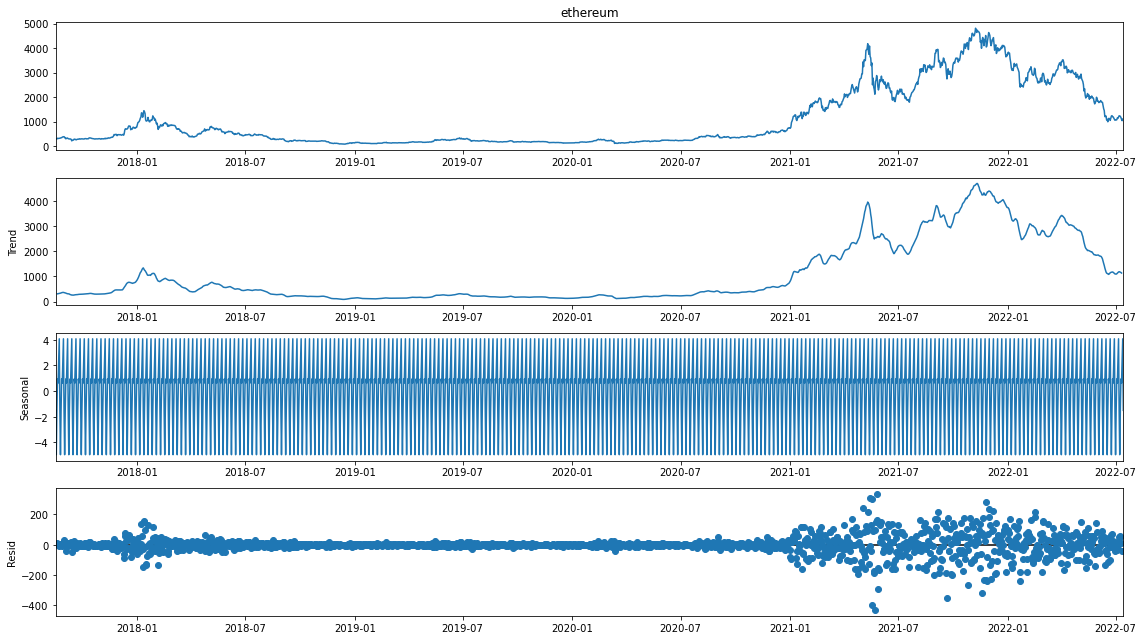

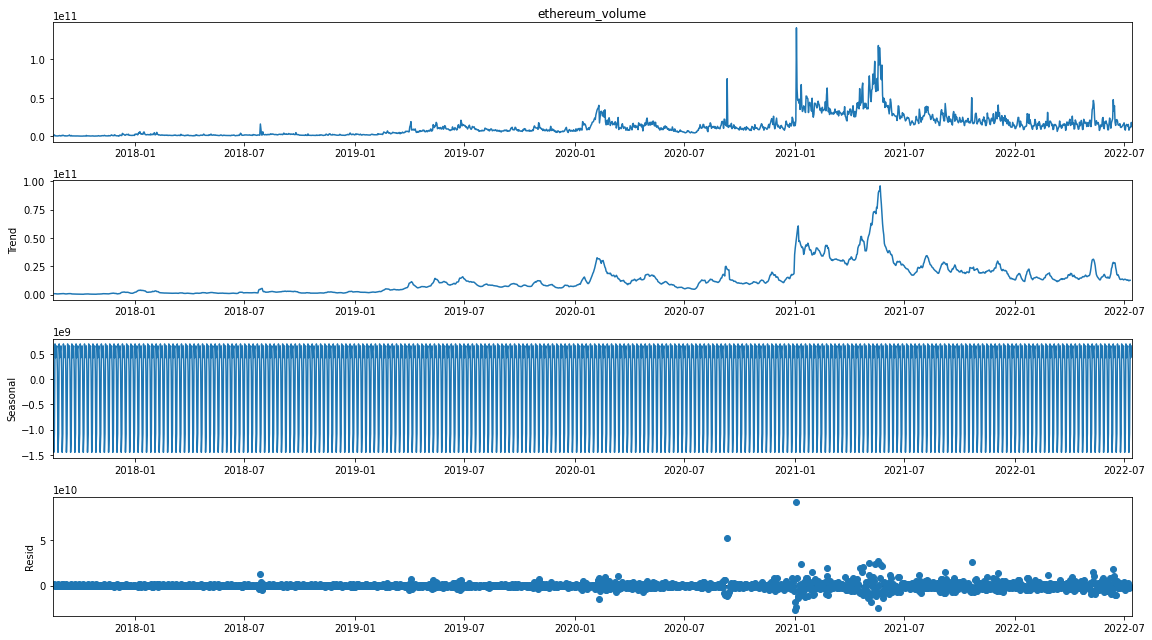

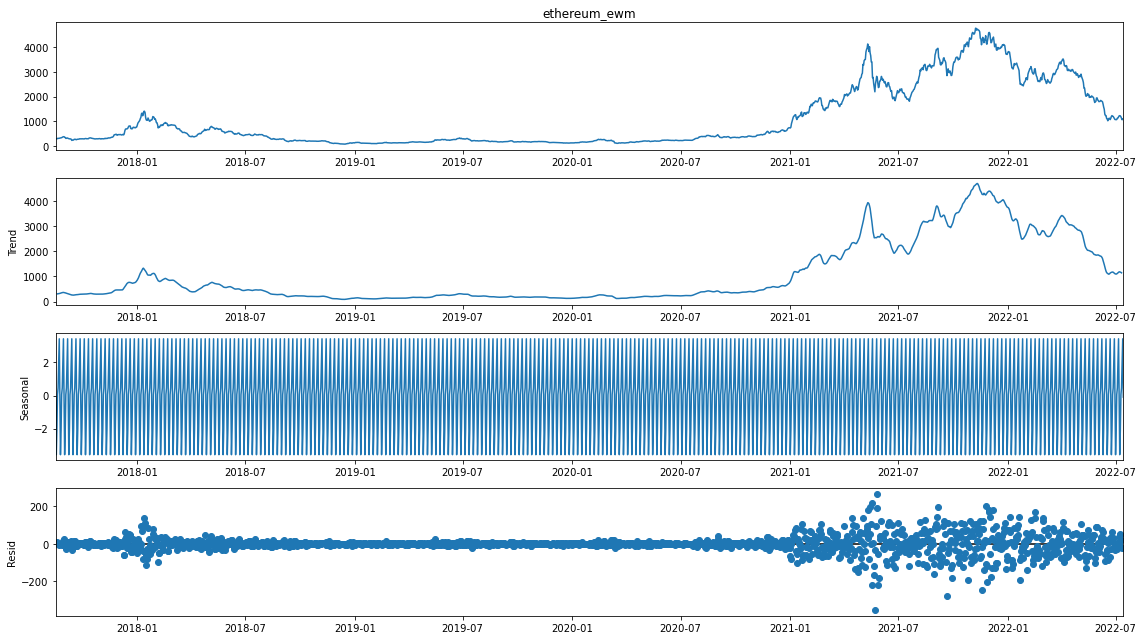

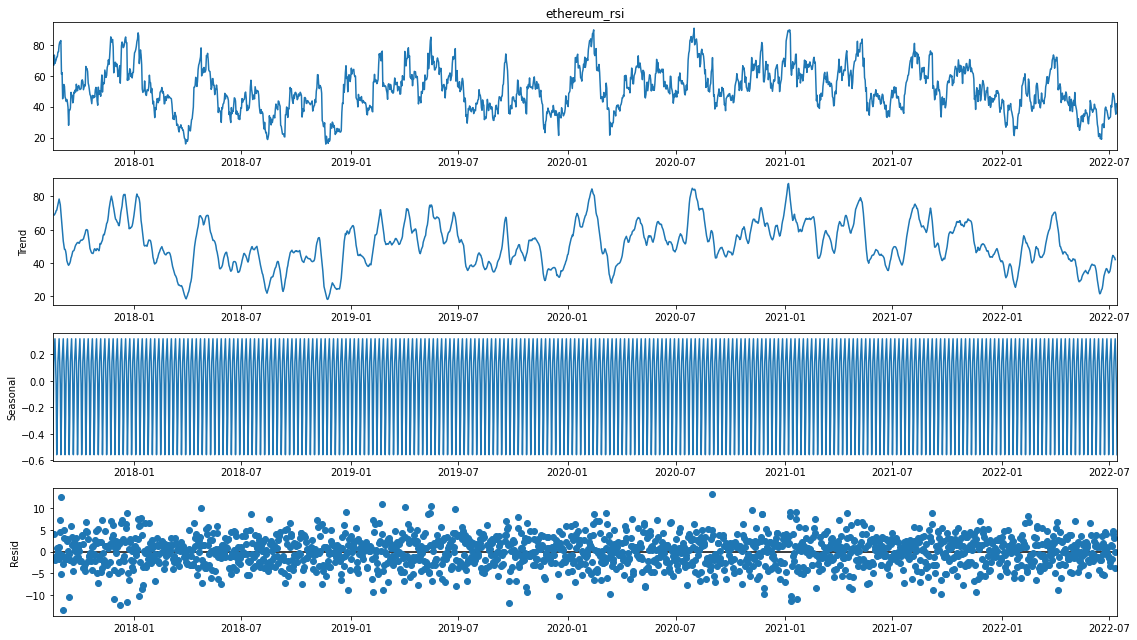

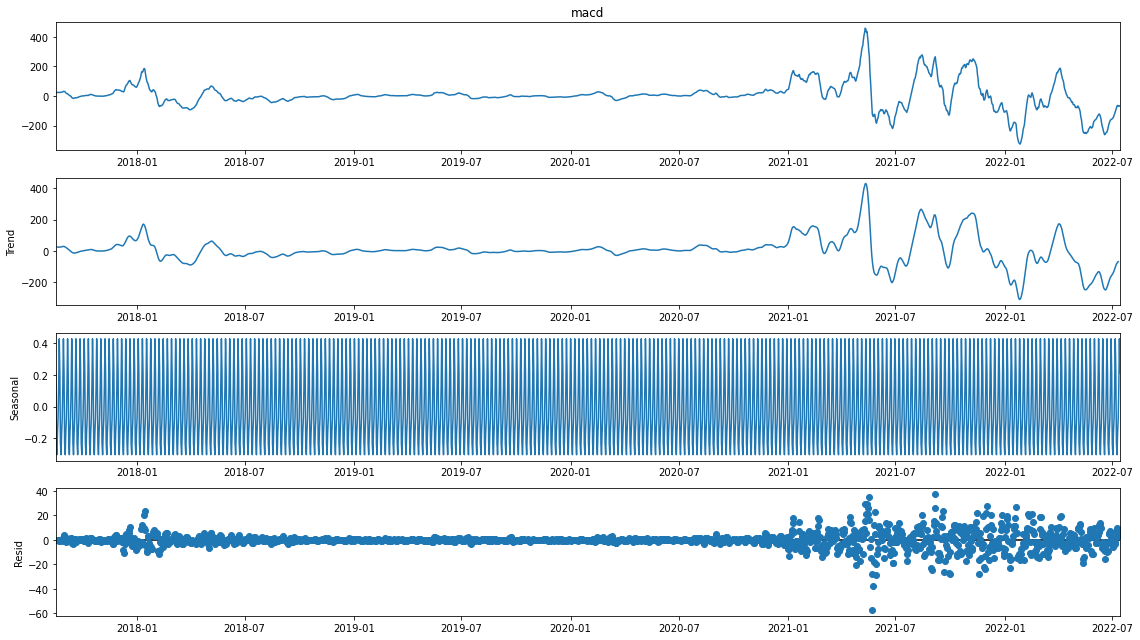

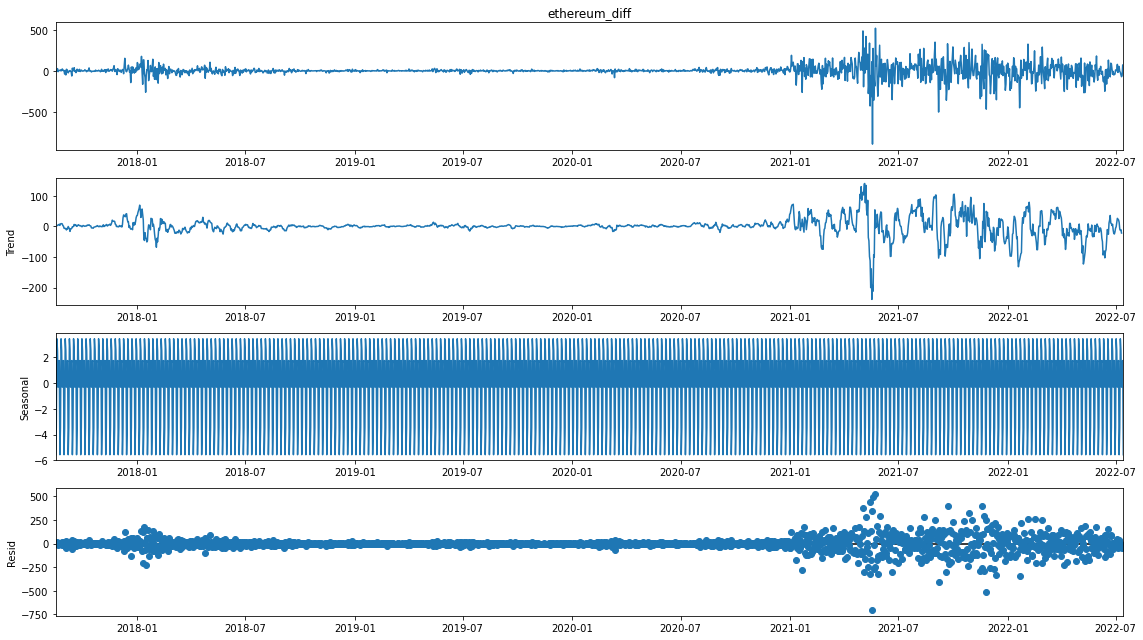

In [64]:
import statsmodels.api
import statsmodels as sm

myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']
for i in myCols:
    res = sm.tsa.seasonal.seasonal_decompose(mydf[i],model='additive')
    fig = res.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout()
    plt.show()

In [65]:
my_data = mydf[myCols]
display(my_data)
my_data.corr()

,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
date,,,,,,
2017-08-17,296.114635,5.904704e+08,297.133944,67.442249,25.878908,-4.455708
2017-08-18,296.622090,5.537022e+08,296.768334,67.574501,24.685977,0.507454
2017-08-19,295.171577,3.428230e+08,295.627793,66.744372,23.354312,-1.450512
2017-08-20,322.201220,1.743910e+09,314.608812,73.323330,24.201050,27.029643
2017-08-21,312.174471,8.983443e+08,312.869997,67.951405,23.788798,-10.026750
...,...,...,...,...,...,...
2022-07-10,1169.012708,1.037447e+10,1183.750575,43.229436,-64.244404,-47.836999
2022-07-11,1097.449438,1.169316e+10,1122.106906,38.448602,-65.652390,-71.563270
2022-07-12,1040.797146,1.155580e+10,1064.028506,35.135851,-70.526609,-56.652293


,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,ethereum_diff
ethereum,1.000000,0.533111,0.999824,0.087455,0.184351,0.030256
ethereum_volume,0.533111,1.000000,0.534166,0.228244,0.277461,-0.041977
ethereum_ewm,0.999824,0.534166,1.000000,0.081729,0.182101,0.012299
ethereum_rsi,0.087455,0.228244,0.081729,1.000000,0.603851,0.233221
macd,0.184351,0.277461,0.182101,0.603851,1.000000,0.074172
ethereum_diff,0.030256,-0.041977,0.012299,0.233221,0.074172,1.000000


## Train Test Split

In [73]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd']]
y = my_data['ethereum']
X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-20]
X_test = X[-20:]
y_train = y[:-20]
y_test = y[-20:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

display(X.head(5))
display(X.tail(5))

# X = X.shift(1, freq='d')

# display(X.head(5))
# display(X.tail(5))


X_train: 
(1773, 4)
X_test: 
(20, 4)
y_train: 
(1773,)
y_test: 
(20,)


,ethereum_volume,ethereum_ewm,ethereum_rsi,macd
date,,,,
2017-08-18,5.904704e+08,297.133944,67.442249,25.878908
2017-08-19,5.537022e+08,296.768334,67.574501,24.685977
2017-08-20,3.428230e+08,295.627793,66.744372,23.354312
2017-08-21,1.743910e+09,314.608812,73.323330,24.201050
2017-08-22,8.983443e+08,312.869997,67.951405,23.788798


,ethereum_volume,ethereum_ewm,ethereum_rsi,macd
date,,,,
2022-07-11,1.037447e+10,1183.750575,43.229436,-64.244404
2022-07-12,1.169316e+10,1122.106906,38.448602,-65.652390
2022-07-13,1.155580e+10,1064.028506,35.135851,-70.526609
2022-07-14,1.793689e+10,1098.951561,41.988562,-67.788266
2022-07-15,1.314164e+10,1090.491402,40.345806,-66.929518


In [67]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# # The coefficients
# print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
# plt.scatter(X_test, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

Root Mean squared error: 12.72


In [68]:
display(X_train)
display(y_pred)
display(y_test)

,ethereum_volume,ethereum_ewm,ethereum_rsi,macd
date,,,,
2017-08-17,5.904704e+08,297.133944,67.442249,25.878908
2017-08-18,5.537022e+08,296.768334,67.574501,24.685977
2017-08-19,3.428230e+08,295.627793,66.744372,23.354312
2017-08-20,1.743910e+09,314.608812,73.323330,24.201050
2017-08-21,8.983443e+08,312.869997,67.951405,23.788798
...,...,...,...,...
2022-06-20,1.981775e+10,1121.942723,28.816407,-253.337180
2022-06-21,1.483820e+10,1123.813201,28.596694,-246.659466
2022-06-22,1.433122e+10,1071.856678,26.464570,-244.478942


array([1228.85572173, 1205.97348181, 1194.20278257, 1152.94821819,
       1108.11666445, 1065.01406193, 1061.07361848, 1061.61072147,
       1066.24289672, 1126.54944217, 1127.82802397, 1170.67406717,
       1221.60809011, 1229.38652107, 1220.89263126, 1181.02629992,
       1116.01610278, 1055.92258039, 1093.48773082, 1085.18694823])

date
2022-06-25    1244.286204
2022-06-26    1201.237791
2022-06-27    1194.224508
2022-06-28    1143.533536
2022-06-29    1098.905518
2022-06-30    1057.630999
2022-07-01    1068.819440
2022-07-02    1068.541503
2022-07-03    1074.607318
2022-07-04    1153.348315
2022-07-05    1134.017070
2022-07-06    1188.725643
2022-07-07    1240.378406
2022-07-08    1233.514679
2022-07-09    1216.849707
2022-07-10    1169.012708
2022-07-11    1097.449438
2022-07-12    1040.797146
2022-07-13    1112.920783
2022-07-14    1087.107339
Name: ethereum, dtype: float64